# Tabular Kaggle Project

Guideline for steps for the Kaggle Tabular Project. You will "turn in" a GitHub repository, modeled after [Project Template](https://github.com/UTA-DataScience/ProjectTempate) on the day of the final, Friday, May 2 at 11 – 1:30 pm. During the final period we will have about 5 minutes to go over your project and your results.

You can find a list of possible Tabular datasets here on [Excel File in Teams](https://mavsuta.sharepoint.com/:x:/r/teams/Course_2252_data_3402_001-NLyiqHJ5btv8Y/Shared%20Documents/General/Kaggle%20Tabular%20Datasets.xlsx?d=w34cdd3378d1146a2ab63700189a8c5b5&csf=1&web=1&e=6ASD5s). You are not limited to these datasets. If you find a Kaggle challenge not listed that you would like to attempt, please go check with Dr. Farbin to make sure it is viable.

This notebook outlines the steps you should follow. The file(s) in the GitHub repository should contain these steps. Note that you will be only considering classification projects.

## Define Project

* Provide Project link.
* Short paragraph describing the challenge. 
* Briefly describe the data.



### Project Link
[Kaggle Playground Series - Season 3, Episode 23](https://www.kaggle.com/competitions/playground-series-s3e23)

### Challenge Overview

The goal of this challenge is to build a machine learning model that can accurately predict whether a software file contains a defect based on a variety of code metrics and software engineering features. This is a binary classification task where the target variable, `defects`, indicates whether a defect is present (`1`) or not (`0`).

Participants aim to minimize **logarithmic loss (log loss)** on the unseen test set, which measures the quality of predicted probabilities. A lower log loss indicates better probabilistic calibration and model confidence.

---

### Dataset Description

The dataset includes over 100,000 rows in the training set and over 67,000 rows in the test set. Each row represents a software unit with several features describing aspects of its structure, complexity, and behavior — such as lines of code, branch counts, operands, operators, and more.

- The **target variable** is `defects` (binary: 0 = no defect, 1 = defect)
- The **features** are primarily numerical and include code metrics like `v(g)`, `ev(g)`, `branchCount`, `IOCode`, etc.
- The dataset is imbalanced, with a higher proportion of non-defective samples, requiring strategies like class weighting or threshold tuning to optimize performance.


## Data Loading and Initial Look

* Load the data. 
* Count the number of rows (data points) and features.
* Any missing values? 
* Make a table, where each row is a feature or collection of features:
    * Is the feature categorical or numerical
    * What values? 
        * e.g. for categorical: "0,1,2"
        * e.g. for numerical specify the range
    * How many missing values
    * Do you see any outliers?
        * Define outlier.
* For classification is there class imbalance?
* What is the target:
    * Classification: how is the target encoded (e.g. 0 and 1)?
    * Regression: what is the range?

### Loading the Data

In [1]:
import pandas as pd

# Load the training and test datasets
train_df = pd.read_csv('../data/train.csv')

# Display the first few rows of the training data
train_df.head()


,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


### Count the number of rows (data points) and features.

In [2]:
# Get the shape of the training data
num_rows, num_features = train_df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of features (including target): {num_features}")


Number of rows: 101763
Number of features (including target): 23


### Check for Missing Values

In [3]:
# Check for missing values in the training data
missing_values = train_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])


Missing values in each column:
Series([], dtype: int64)


### Feature Summary Table

In [4]:
import tabulate

# Exclude the target column from features
features = train_df.drop(columns=['defects'])

# Initialize the summary table
summary_table = []

for col in features.columns:
    col_data = train_df[col]
    # Determine the type of data (categorical or numerical)
    # and calculate statistics accordingly
    data_type = 'Categorical' if col_data.nunique() < 10 else 'Numerical'
    unique_values = col_data.unique() if data_type == 'Categorical' else f"{col_data.min()} to {col_data.max()}"
    missing = col_data.isnull().sum()
    mean = col_data.mean()
    std = col_data.std()
    
    # Calculate outliers using the 3-sigma rule
    # (values outside mean ± 3 * std are considered outliers)
    outliers = ((col_data < (mean - 3 * std)) | (col_data > (mean + 3 * std))).sum()
    
    summary_table.append({
        'Feature': col,
        'Type': data_type,
        'Values': unique_values if data_type == 'Categorical' else f"{col_data.min()} to {col_data.max()}",
        'Missing Values': missing,
        'Summation of Outliers': outliers
    })

# Convert the summary table to a DataFrame for better visualization
summary_df = pd.DataFrame(summary_table)

# Display the summary table
print("Summary of features:")
print(tabulate.tabulate(summary_df, headers='keys', tablefmt='psql', showindex=False))

Summary of features:
+-------------------+-----------+--------------------+------------------+-------------------------+
| Feature           | Type      | Values             |   Missing Values |   Summation of Outliers |
|-------------------+-----------+--------------------+------------------+-------------------------|
| id                | Numerical | 0 to 101762        |                0 |                       0 |
| loc               | Numerical | 1.0 to 3442.0      |                0 |                    1401 |
| v(g)              | Numerical | 1.0 to 404.0       |                0 |                    1479 |
| ev(g)             | Numerical | 1.0 to 165.0       |                0 |                    1980 |
| iv(g)             | Numerical | 1.0 to 402.0       |                0 |                     853 |
| n                 | Numerical | 0.0 to 8441.0      |                0 |                    1507 |
| v                 | Numerical | 0.0 to 80843.08    |                0 |      

### Check for Class Imbalance

In [5]:
# Check the distribution of the target variable
class_distribution = train_df['defects'].value_counts(normalize=True)
print("Class distribution:")
print(class_distribution)


Class distribution:
defects
False    0.773356
True     0.226644
Name: proportion, dtype: float64


### Target Variable Details

The target column is `defects`. The target is a classification problem. The target is encoded as 0 (False) and 1 (True). The target is imbalanced with 0 being the majority class and 1 being the minority class. The target has no missing values.

In [6]:
target_counts = train_df['defects'].value_counts()
print("Target variable counts:")
print(target_counts)

# Display the range of the target variable
target_range = (train_df['defects'].min(), train_df['defects'].max())
print(f"Target variable range: {target_range}")

Target variable counts:
defects
False    78699
True     23064
Name: count, dtype: int64
Target variable range: (np.False_, np.True_)


## Data Visualization

* For classification: compare histogram every feature between the classes. Lots of examples of this in class.
* For regression: 
    * Define 2 or more class based on value of the regression target.
        * For example: if regression target is between 0 and 1:
            * 0.0-0.25: Class 1
            * 0.25-0.5: Class 2
            * 0.5-0.75: Class 3
            * 0.75-1.0: Class 4
    * Compare histograms of the features between the classes.
        
* Note that for categorical features, often times the information in the histogram could be better presented in a table.    
* Make comments on what features look most promising for ML task.

### Classification
* For each feature, plot the histogram of the feature for each class.

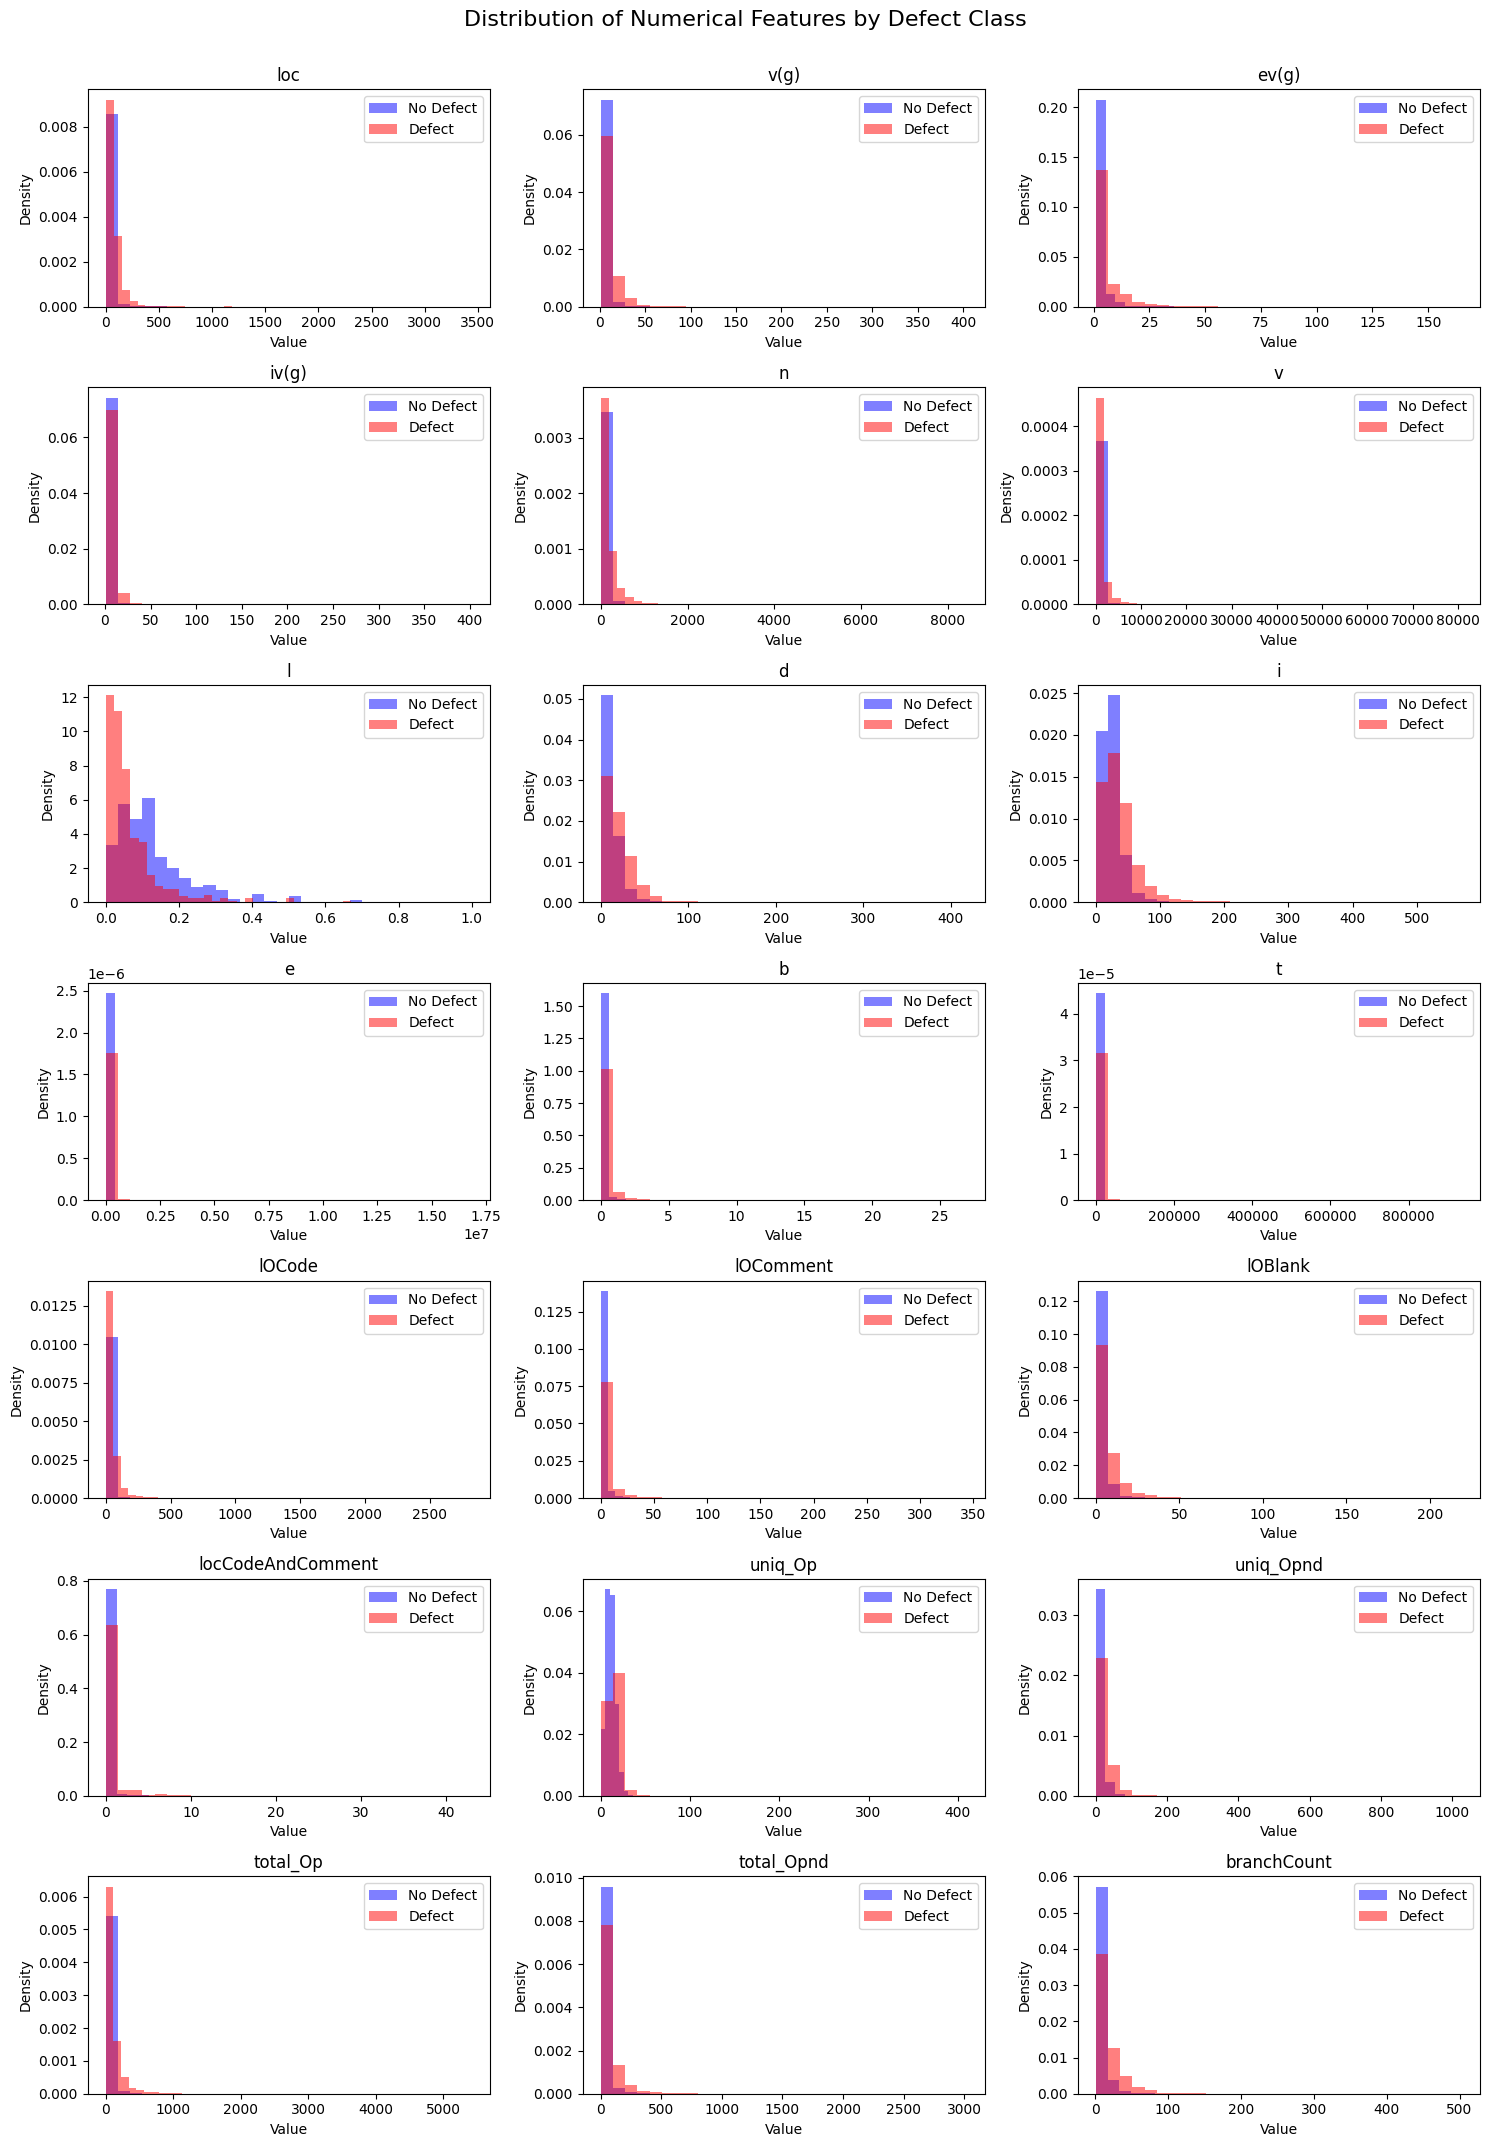

In [7]:
import matplotlib.pyplot as plt
import math

# Get numerical features only (excluding target)
numerical_features = train_df.select_dtypes(include=['int64', 'float64', 'bool']).drop(columns=['defects','id']).columns

# Grid config
n_cols = 3
n_rows = math.ceil(len(numerical_features) / n_cols)

# Plot setup
plt.figure(figsize=(n_cols * 5, n_rows * 3))

for idx, feature in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, idx)
     # Plot histogram for non-defective class (defects = 0)
    plt.hist(train_df[train_df['defects'] == 0][feature], bins=30, alpha=0.5, label='No Defect', color='blue', density=True)
    
    # Plot histogram for defective class (defects = 1)
    plt.hist(train_df[train_df['defects'] == 1][feature], bins=30, alpha=0.5, label='Defect', color='red', density=True)
    
    # Add title and labels
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel("Density")
    plt.legend(loc='upper right')
    plt.tight_layout()

plt.suptitle("Distribution of Numerical Features by Defect Class", fontsize=16, y=1.02)
plt.show()


## Observations on Feature Distributions

### Most Promising Features for ML:
- **`l`**: Shows a clear separation between defective and non-defective classes. This is likely to be a strong predictor.
- **`branchCount`**, **`uniq_Op`**, **`total_Opnd`**: These features show noticeable shifts in distribution between the two classes, especially in the lower ranges. They are likely to contribute to classification performance.
- **`IOCode`**, **`IOComment`**: Show subtle but consistent differences between classes. These could be helpful in combination with other features.

### Likely Less Useful Features:
- **`id`**: Uniform distribution across the dataset. This is just an identifier and I will drop it from modeling.
- **`e`**, **`t`**, **`v`**, **`i`**: These have extreme outliers and very sparse distributions. Either I will drop it or apply transformations like log-scaling or clipping.
- **`locCodeAndComment`**, **`IOBlank`**, **`uniq_Opnd`**: Nearly identical distributions across both classes, which suggests low predictive power.

### Additional Notes:
- Most features are **right-skewed** and would benefit from log transformation or normalization.
- Going to scale the features to make sure I don't have any premature dropping of features.
- Consider visualizing **categorical or boolean features** in frequency tables instead of histograms for better clarity.



## Data Cleaning and Preperation for Machine Learning

* Perform any data cleaning. Be clear what are you doing, for what feature. 
* Determinine if rescaling is important for your Machine Learning model.
    * If so select strategy for each feature.
    * Apply rescaling.
* Visualize the features before and after cleaning and rescaling.
* One-hot encode your categorical features.

### Data Cleaning: Handle Unwanted or Useless Features

* Drop the `id` column as it is just an identifier and does not provide any useful information for the model.

In [8]:
# Drop the 'id' column — it's just an identifier and not useful for prediction
train_df_clean = train_df.drop(columns=['id'])

# Confirm no missing values
print("Confirming no missing values in the cleaned training data:")
print("Missing values per column:")
print(train_df_clean.isnull().sum())


Confirming no missing values in the cleaned training data:
Missing values per column:
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


### Determine and Apply Feature Scaling

Here we are going to apply **StandardScaler** and **log1p** to the features and see if it improves any of the features distributions.

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def preprocess_features(df):
    X = df.copy()
    # Apply log1p to all features
    X_log_scaled = X.copy()
    for col in X.columns:
        X_log_scaled[col] = np.log1p(X[col])

    # Standard scaling
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_log_scaled), columns=X.columns)

    return X_scaled

# Preprocess the training data
y_train = train_df_clean['defects']
train_df_clean = train_df_clean.drop(columns=['defects'])

X_train = preprocess_features(train_df_clean)

### Visualize Features Before and After Cleaning/Scaling

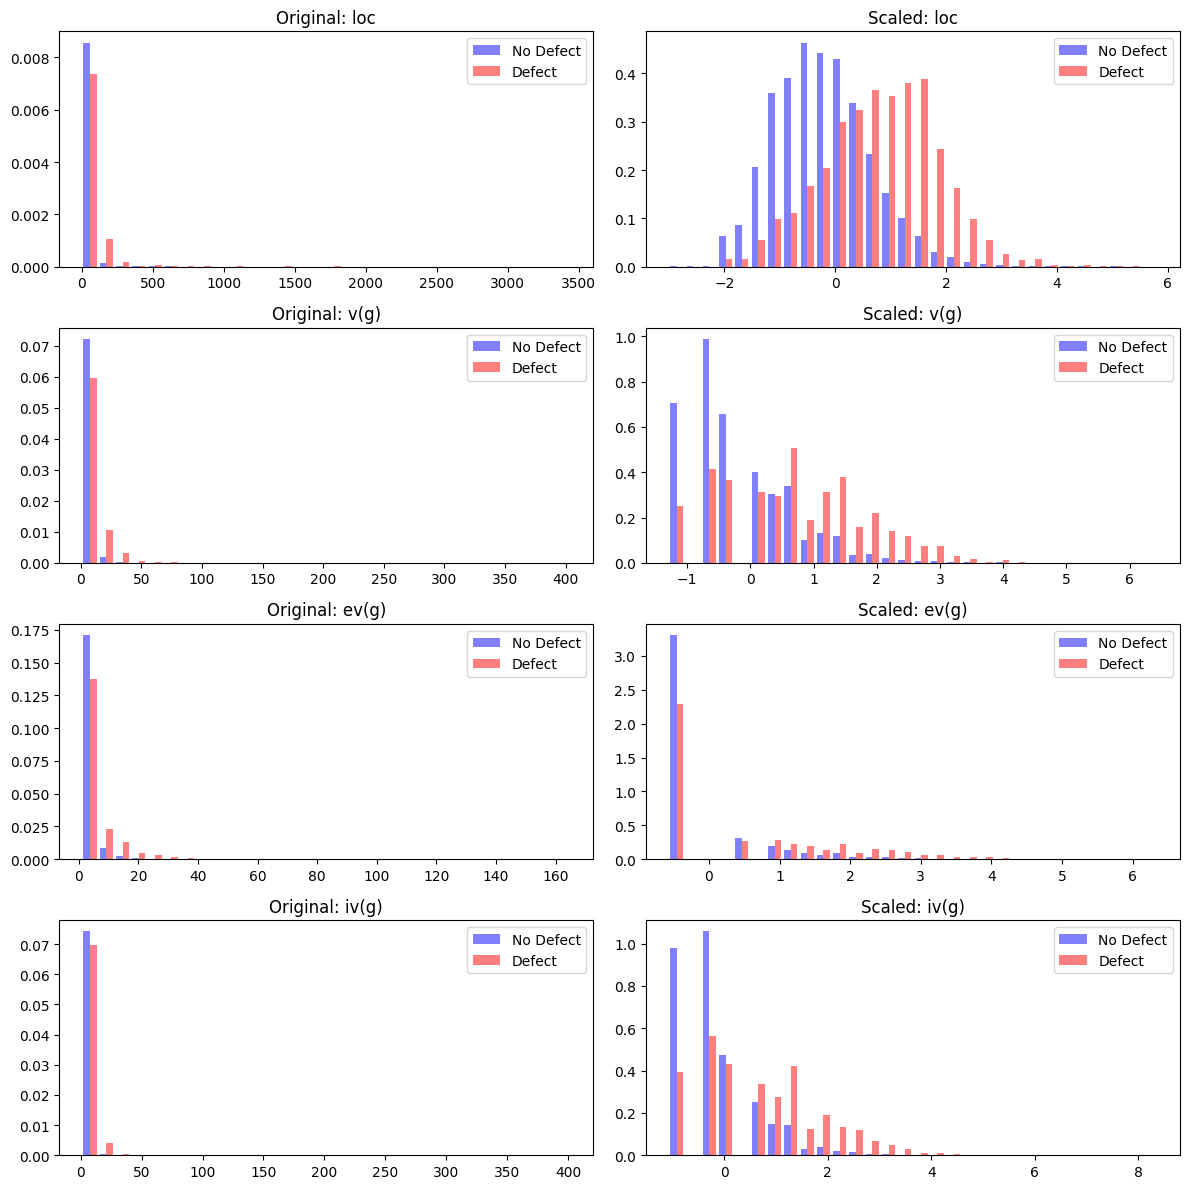

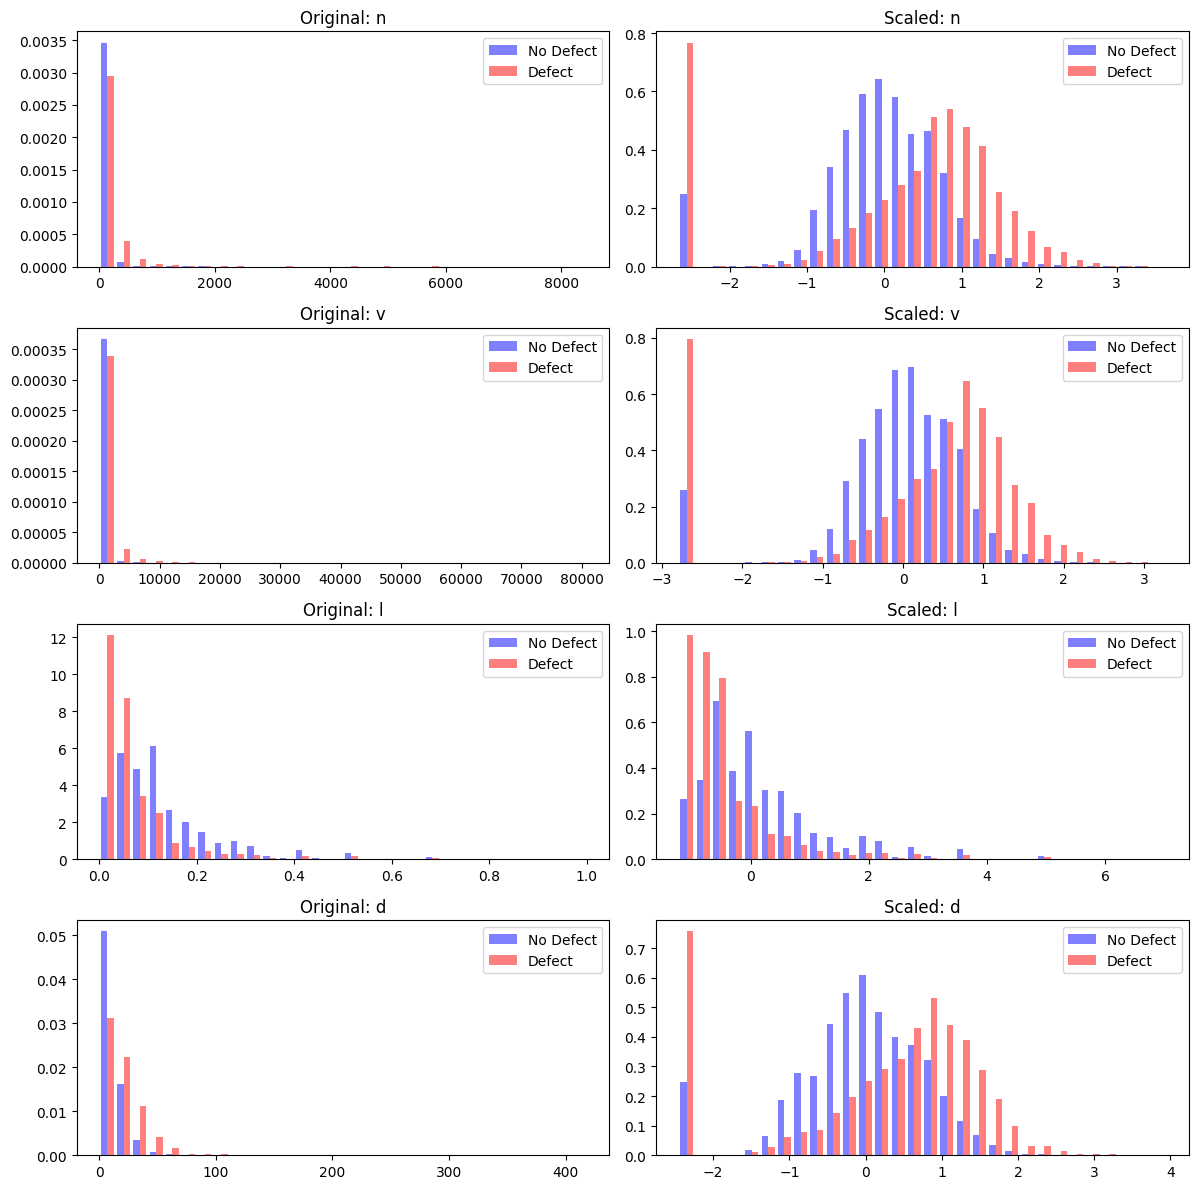

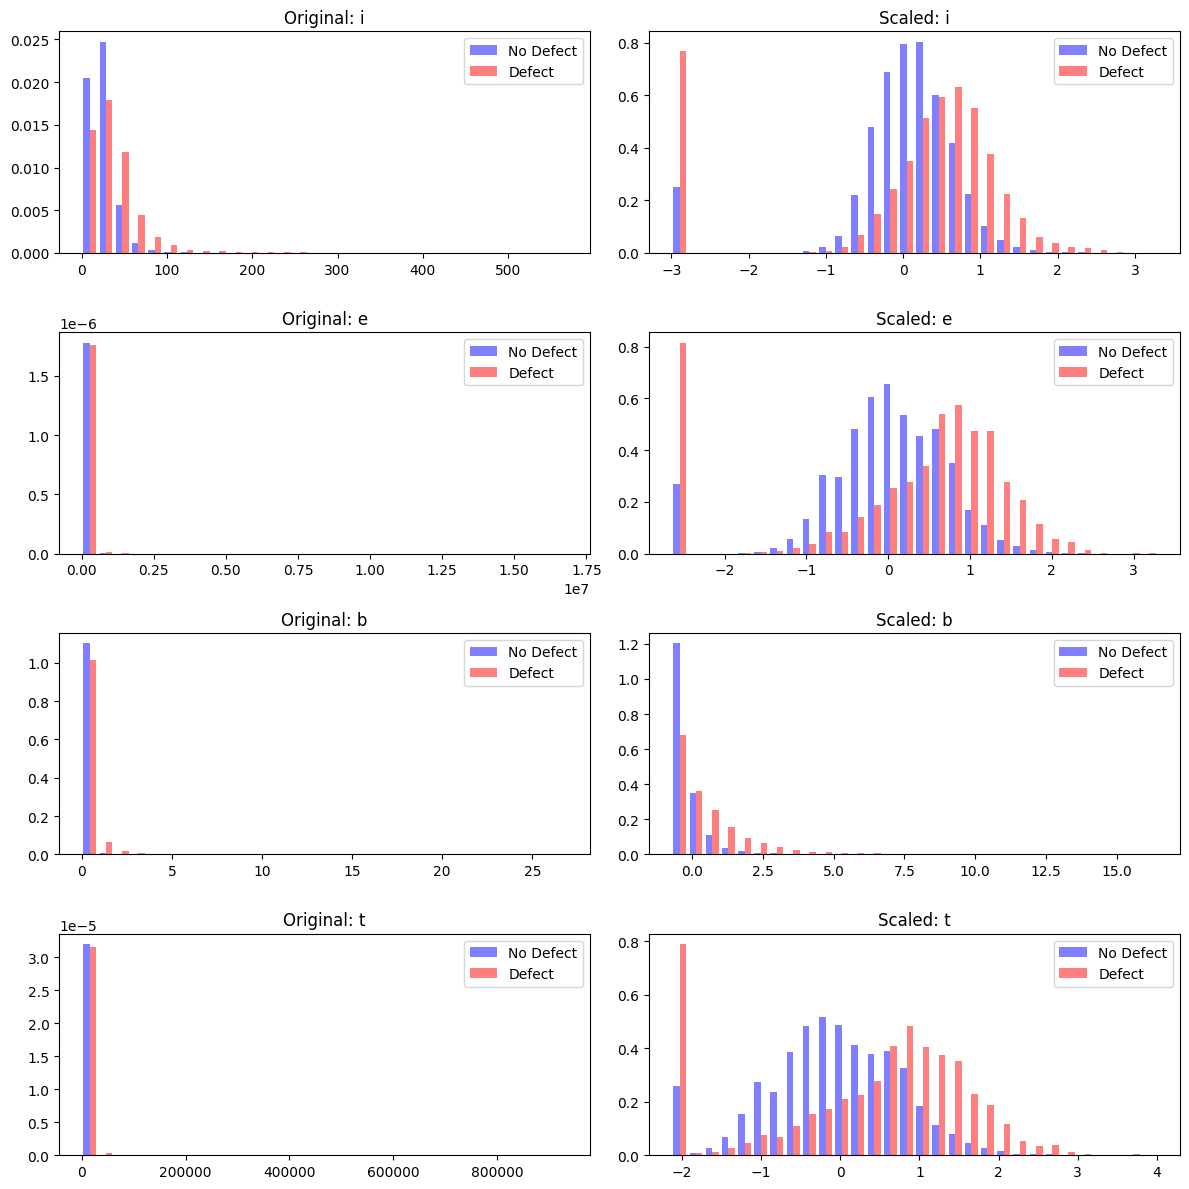

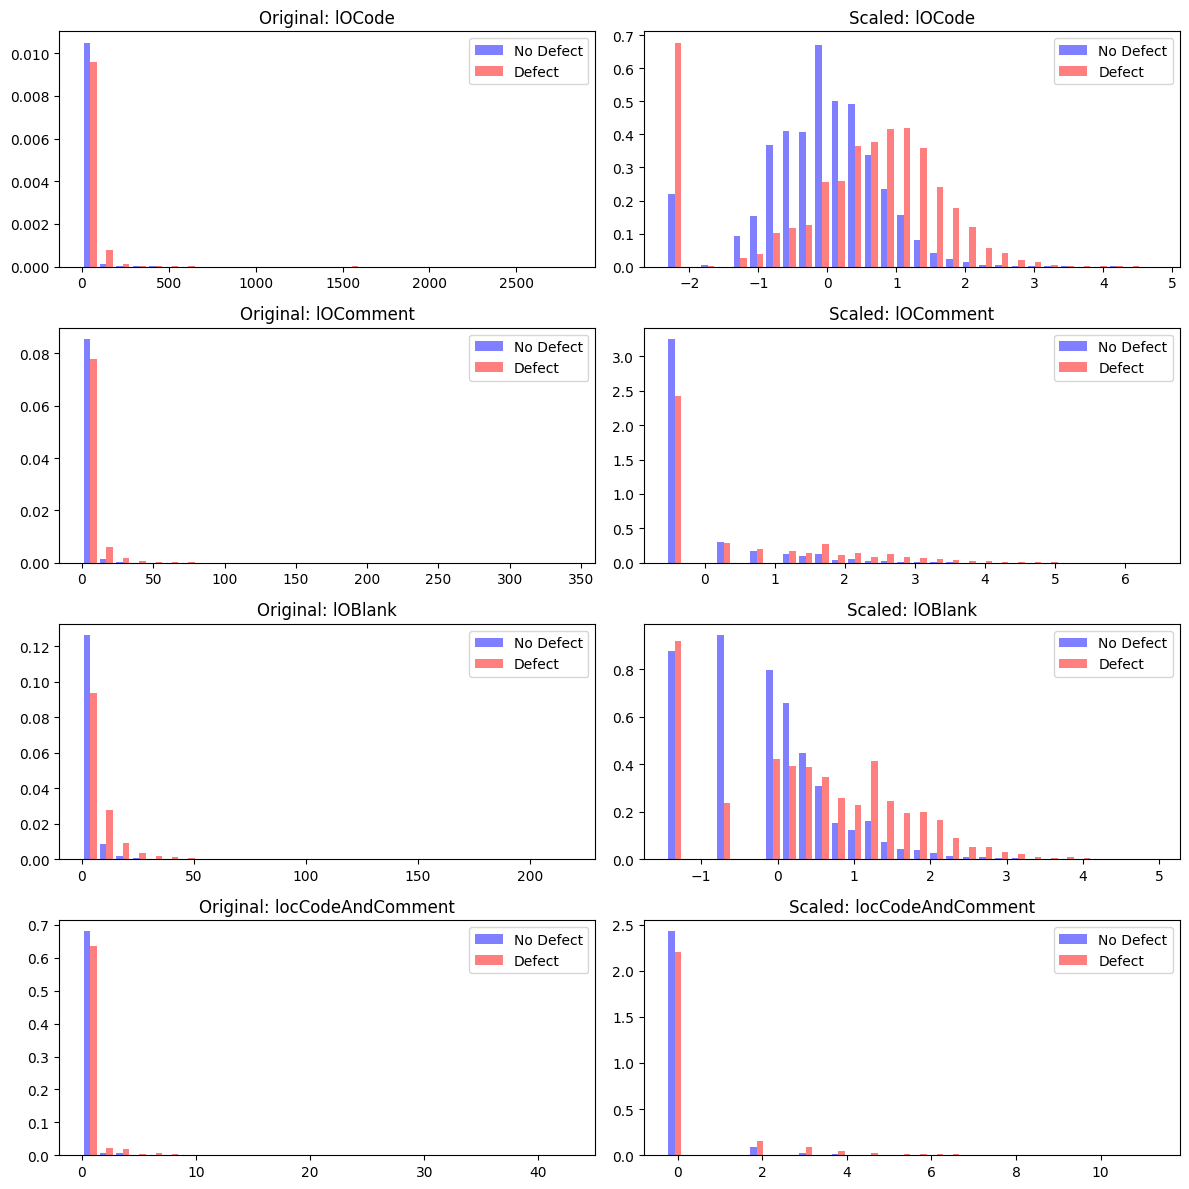

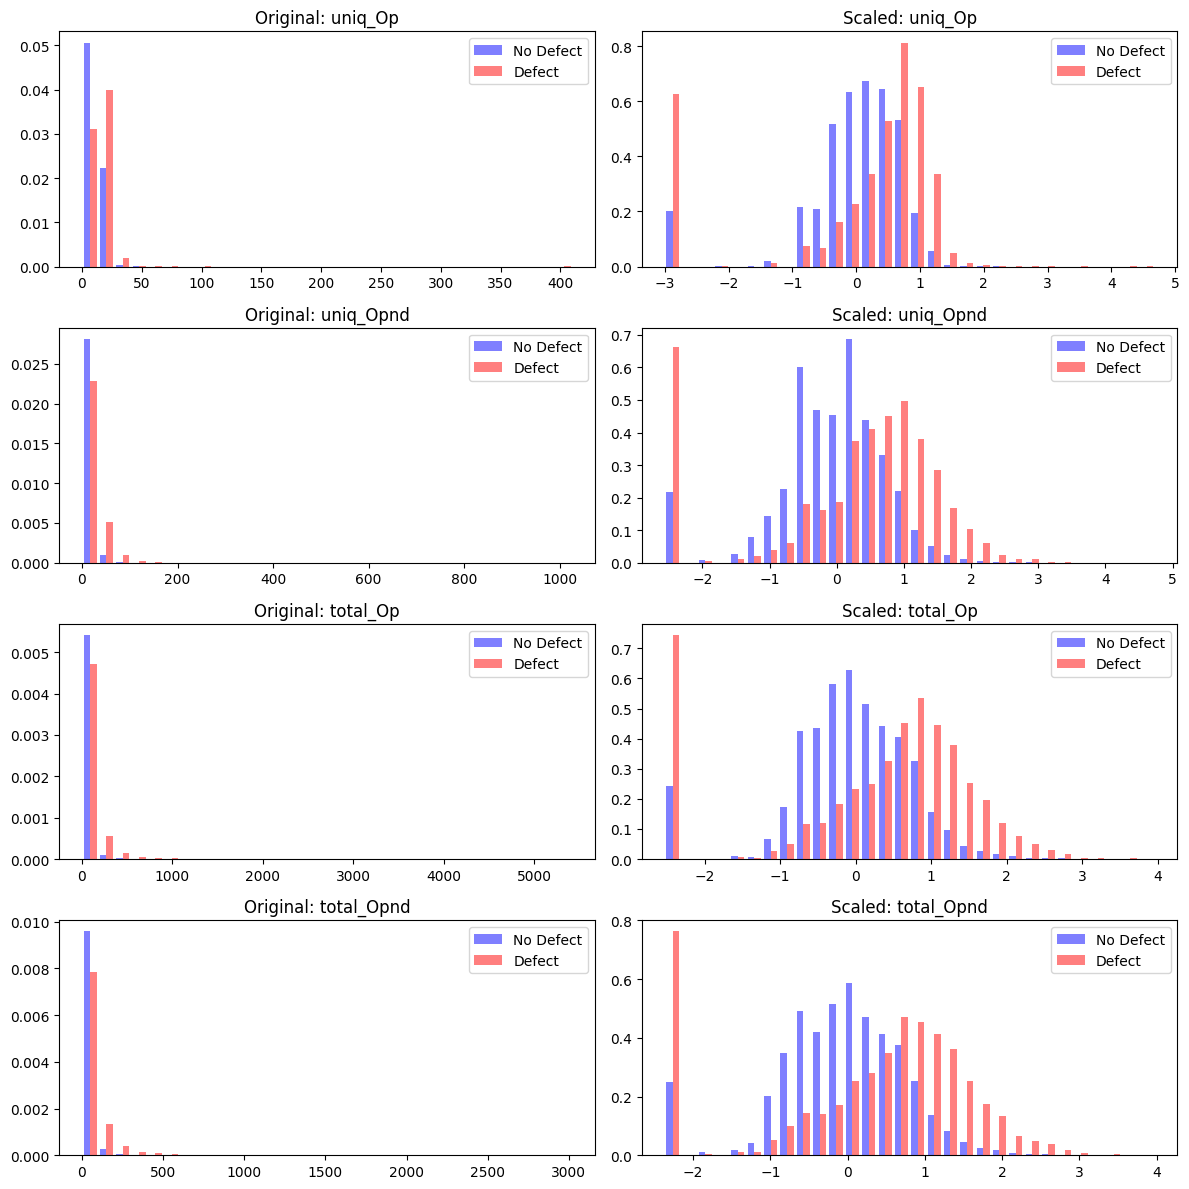

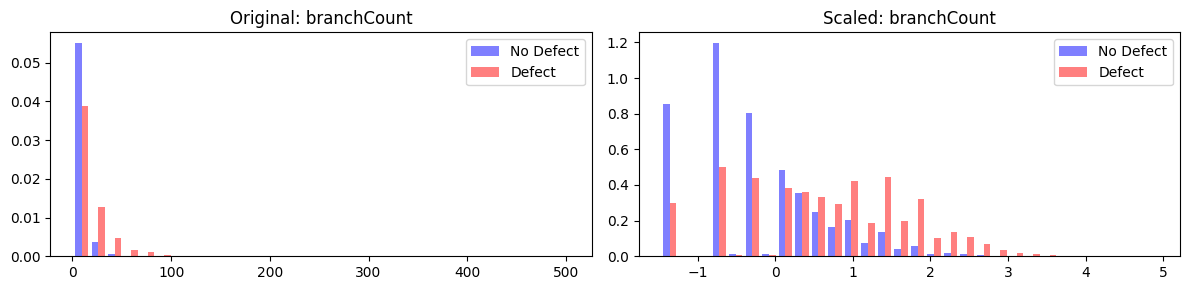

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Add target back to original and scaled feature sets
X_with_target = train_df_clean.copy()
X_with_target['defects'] = y_train

X_scaled_with_target = X_train.copy()
X_scaled_with_target['defects'] = y_train

# Config
features_per_fig = 4
features = X_train.columns.tolist()

for i in range(0, len(features), features_per_fig):
    feature_group = features[i:i + features_per_fig]
    n_rows = len(feature_group)
    
    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 3 * n_rows))
    
    # If only one feature, axs will be 1D — force it into 2D
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for j, feature in enumerate(feature_group):
        # Original
        axs[j][0].hist(
            [X_with_target[X_with_target['defects'] == 0][feature],
             X_with_target[X_with_target['defects'] == 1][feature]],
            bins=30, alpha=0.5, label=['No Defect', 'Defect'], color=['blue', 'red'], density=True
        )
        axs[j][0].set_title(f"Original: {feature}")
        axs[j][0].set_xlabel("")
        axs[j][0].legend()

        # Scaled
        axs[j][1].hist(
            [X_scaled_with_target[X_scaled_with_target['defects'] == 0][feature],
             X_scaled_with_target[X_scaled_with_target['defects'] == 1][feature]],
            bins=30, alpha=0.5, label=['No Defect', 'Defect'], color=['blue', 'red'], density=True
        )
        axs[j][1].set_title(f"Scaled: {feature}")
        axs[j][1].set_xlabel("")
        axs[j][1].legend()
    
    plt.tight_layout()
    plt.show()



### One-Hot Encode Categorical Features

In [11]:
# Check for categorical columns
categorical_cols = train_df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)

print("Since there are no categorical columns, we can proceed with dropping the columns & model training.")


Categorical columns to encode: []
Since there are no categorical columns, we can proceed with dropping the columns & model training.


### Updated Observations on Feature Distributions with Scaling

After visualizing all features before and after cleaning + scaling, it helps me to better assess which features are likely to help my classification model.

####  Keeping These Features (Good Class Separation / Distinct Distributions)

These features show a visible **shift between the True and False defect classes**, especially after scaling:
- **`l`**: Clear class separation maintained after scaling. Highly promising.
- **`branchCount`**: Shows strong shift between classes, particularly in the lower range.
- **`uniq_Op`**, **`total_Op`**, **`total_Opnd`**: After scaling, class distributions separate cleanly.
- **`v(g)`**, **`iv(g)`**, **`ev(g)`**: Retain some distinguishability between classes.
- **`IOCode`**, **`IOComment`**: Some overlap, but separation improves after transformation.
- **`n`**, **`d`**, **`i`**: Reasonable divergence post-scaling.


#### Going to Drop These (Very Similar Across Classes)

These features show **minimal class separation**, even after scaling. They might add noise or redundancy:
- **`locCodeAndComment`**: Distributions nearly identical.
- **`IOBlank`**: Significant overlap across both classes.
- **`e`**, **`t`**, **`v`**: Despite rescaling, these features show either heavy noise or class imbalance in density peaks.
- **`b`**: No useful visual separation.

### Summary Table

| Feature                 | Decision | Reasoning                                                                 |
|-------------------------|----------|---------------------------------------------------------------------------|
| `l`                     |  Keep    | Strong, clear class separation; highly predictive                         |
| `branchCount`           |  Keep    | Maintains strong divergence between classes post-scaling                  |
| `uniq_Op`               |  Keep    | Good separation post-scaling                                              |
| `total_Op`, `total_Opnd`|  Keep    | Both show meaningful class-wise density shifts after scaling              |
| `v(g)`, `iv(g)`, `ev(g)`|  Keep    | Strong right-skewed originally, but retain distinct shapes post-scaling   |
| `IOCode`, `IOComment`   |  Keep    | Not perfect, but moderate separation and variance between classes         |
| `n`, `d`, `i`           |  Keep    | Slight overlap, but decent class-based divergence in scaled distributions |
| `loc`                   |  Keep    | Separation visible after scaling (was borderline before)                  |
| `locCodeAndComment`     |  Drop    | Distributions nearly identical across classes even after scaling          |
| `IOBlank`               |  Drop    | High overlap across classes, minimal signal                               |
| `e`                     |  Drop    | Extreme long tail, noisy distribution, minimal separation                 |
| `t`                     |  Drop    | Same as `e` — very sparse, high-variance, no clean class boundaries       |
| `v`                     |  Drop    | No visual separation, high variance, extremely large values originally    |
| `b`                     |  Drop    | Scaled distribution is noisy with little separation                       |
| `id`                    |  Dropped | Identifier — not predictive                                               |



## Machine Learning


### Problem Formulation

* Remove unneed columns, for example:
    * duplicated
    * categorical features that were turned into one-hot.
    * features that identify specific rows, like ID number.
    * make sure your target is properly encoded also.
* Split training sample into train, validation, and test sub-samples.


### Features to be dropped:

As discussed above in addition to id, I will drop the following features:

- `locCodeAndComment`
- `IOBlank`
- `e`
- `t`
- `v`
- `b`


In [12]:
# Drop the features that are not useful for prediction

def drop_uninformative_features(X, features_to_drop, verbose=True):
    # Drop unwanted features
    X_cleaned = X.drop(columns=features_to_drop)

    # Print info
    if verbose:
        print(f"Final feature set shape: {X_cleaned.shape}")
        print("First few rows of the final feature set:")
        print(X_cleaned.head())

    return X_cleaned

y_train_final = y_train.copy()

features_to_drop = ['locCodeAndComment', 'lOBlank', 'e', 't', 'v', 'b']

X_train_final = drop_uninformative_features(X_train, features_to_drop)



Final feature set shape: (101763, 15)
First few rows of the final feature set:
        loc      v(g)     ev(g)     iv(g)         n         l         d  \
0 -0.116911 -0.283304 -0.569539 -0.354383  0.206128 -0.521675  0.750840   
1 -0.622822 -0.702091 -0.569539 -0.354383 -0.221785  0.343577 -0.248965   
2 -0.886928 -0.702091 -0.569539 -0.354383  0.009550  0.026439 -0.118339   
3 -1.227420 -1.292337 -0.569539 -1.076075 -0.443592  0.854040 -0.510445   
4 -0.886928 -0.702091 -0.569539 -0.354383 -0.643966  0.753685 -0.447926   

          i    lOCode  lOComment   uniq_Op  uniq_Opnd  total_Op  total_Opnd  \
0 -0.296149  0.257178   0.287558  0.611742  -0.141983  0.233234    0.110793   
1  0.071879 -0.105524  -0.543222  0.166892   0.049918 -0.309951   -0.227723   
2  0.143189 -0.362865  -0.543222  0.269121   0.049918  0.009452   -0.083333   
3 -0.085643 -0.888658  -0.543222 -0.200530  -0.517399 -0.393964   -0.725552   
4 -0.421329 -0.468225  -0.543222 -0.350961  -0.517399 -0.722779   -0.473351

### Split the Data
* Split the data into train, validation, and test sets.


In [13]:
from sklearn.model_selection import train_test_split

def split_data(X, target):
    # First split: 60% train, 40% temp (to later split into val and test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, target, test_size=0.4, random_state=42, stratify=target
    )

    # Second split: 50% of temp → val and test (i.e. 20% each of total)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the data
X_train_final, X_val, X_test, y_train_final, y_val, y_test = split_data(X_train_final, y_train_final)

# Check the shapes of the splits
print(f"Training data shape: {X_train_final.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (61057, 15)
Validation data shape: (20353, 15)
Test data shape: (20353, 15)



### Train ML Algorithm

* You only need one algorithm to work. You can do more if you like.
* For now, focus on making it work, rather than best result.
* Try to get a non-trivial result.


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Logistic Regression basic model
basic_lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
basic_lr_model.fit(X_train_final, y_train_final)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [15]:

# Initialize and train with class_weight to handle imbalance
basic_rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
basic_rf_model.fit(X_train_final, y_train_final)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use log loss as the scoring metric
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit the randomized search to the data
random_search.fit(X_train_final, y_train_final)

# Use the best model
best_rf_model = random_search.best_estimator_
print(f"Best parameters for random forest model: {random_search.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  12.9s
[CV] END class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.2s
[CV] END class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.1s
[CV] END class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.1s
[CV] END class_weight=balanced, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.2s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.5s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf


### Evaluate Performance on Validation Sample

* Compute the usual metric for your ML task.
* Compute the score for the kaggle challenge.


Basic Logistic Regression Model evaluation metrics:
              precision    recall  f1-score   support

       False       0.89      0.76      0.82     15740
        True       0.46      0.69      0.55      4613

    accuracy                           0.75     20353
   macro avg       0.68      0.72      0.69     20353
weighted avg       0.79      0.75      0.76     20353



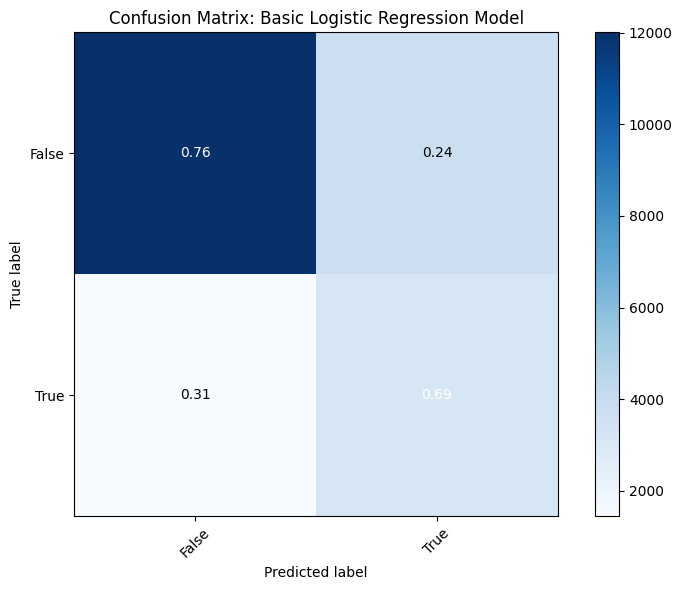

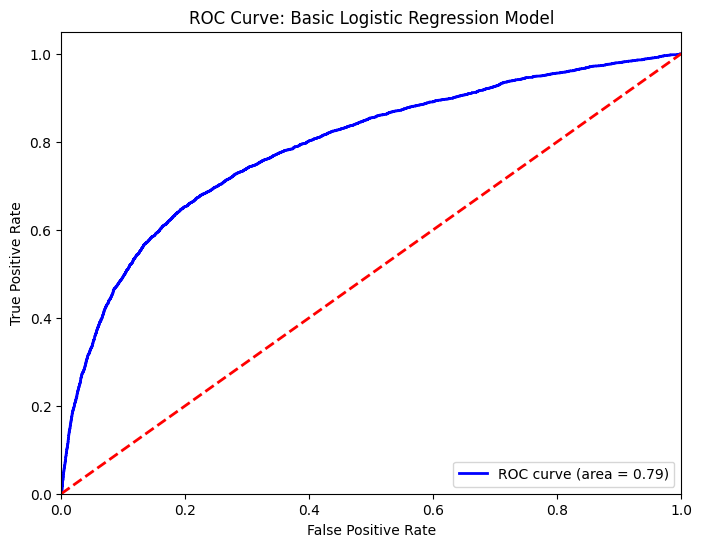

Basic Random Forest Model evaluation metrics:
              precision    recall  f1-score   support

       False       0.83      0.94      0.88     15740
        True       0.64      0.34      0.45      4613

    accuracy                           0.81     20353
   macro avg       0.74      0.64      0.67     20353
weighted avg       0.79      0.81      0.79     20353



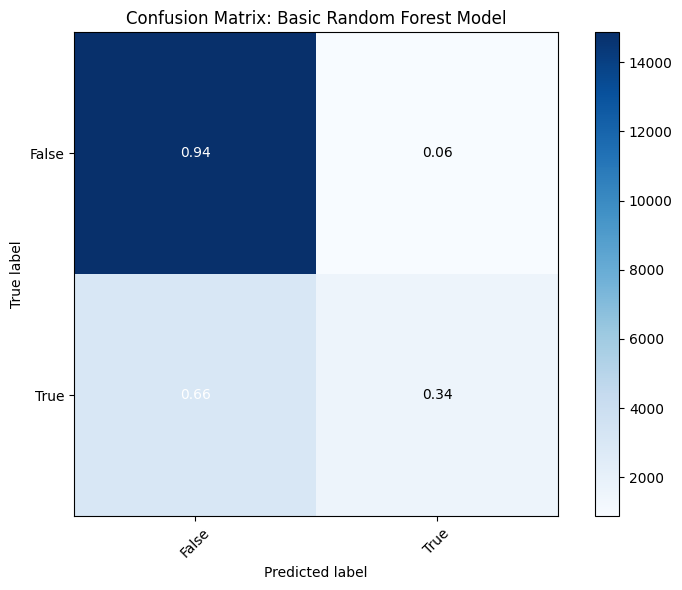

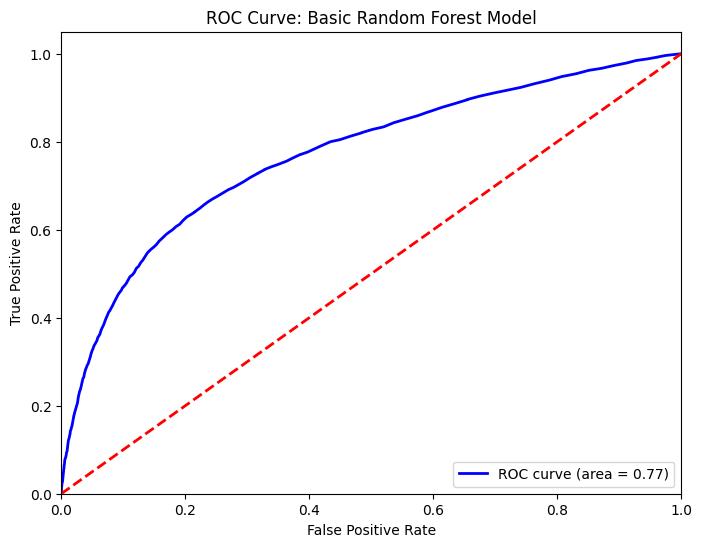

Best Random Forest Model evaluation metrics:
              precision    recall  f1-score   support

       False       0.89      0.80      0.84     15740
        True       0.49      0.65      0.56      4613

    accuracy                           0.77     20353
   macro avg       0.69      0.73      0.70     20353
weighted avg       0.80      0.77      0.78     20353



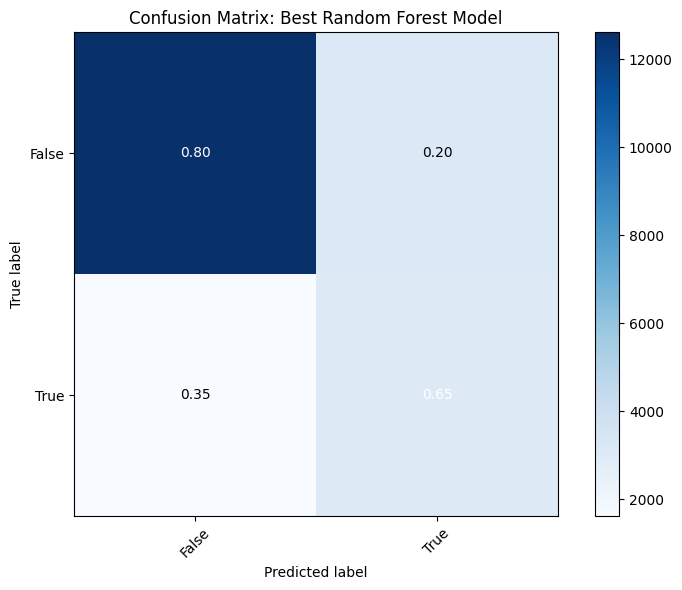

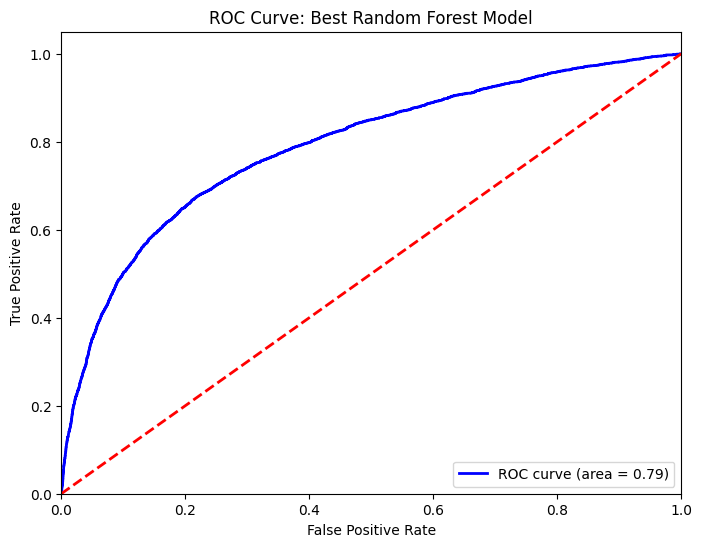

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.colorbar()
    tick_marks = range(len(set(y_true)))
    plt.xticks(tick_marks, set(y_true), rotation=45)
    plt.yticks(tick_marks, set(y_true))
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot normalized values
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j, i, f"{cm_normalized[i, j]:.2f}", ha='center', va='center', color='white' if cm_normalized[i, j] > 0.5 else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X, y, model_name="Model"):
    # Predict on the validation set
    y_pred = model.predict(X)
    
    print(f"{model_name} evaluation metrics:")

    # Print classification report
    print(classification_report(y, y_pred))

    # Plot confusion matrix
    plot_confusion_matrix(y, y_pred, model_name=model_name)

    # Plot ROC curve
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
   

# Evaluate the logistic regression model on the validation set
evaluate_model(basic_lr_model, X_val, y_val, model_name="Basic Logistic Regression Model")

# Evaluate the basic rf model on the validation set
evaluate_model(basic_rf_model, X_val, y_val, model_name="Basic Random Forest Model")

# Evaluate the best rf model on the validation set
evaluate_model(best_rf_model, X_val, y_val, model_name="Best Random Forest Model")


In [17]:
from sklearn.metrics import log_loss
from tabulate import tabulate

def model_auc(model, X, y):
    # Predict probabilities
    y_proba = model.predict_proba(X)[:, 1]  # Get probabilities for the positive class
    
    # Calculate AUC
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    return roc_auc

def model_log_loss(model, X, y):
    # Predict probabilities
    y_proba = model.predict_proba(X)[:, 1]  # Get probabilities for the positive class
    
    # Calculate log loss
    log_loss_value = log_loss(y, y_proba)
    return log_loss_value

models = [basic_lr_model, basic_rf_model, best_rf_model]
names = ['Logistic Regression', 'Basic Random Forest', 'Tuned, Random Forest']

# Example data for tabulation
results = [
    ["Model", "ROC AUC", "Log Loss"]
]

# Create Table
for m, n in zip(models, names):
    ll = f"{model_log_loss(m, X_val, y_val):.4f}"
    area = f"{model_auc(m, X_val, y_val):.4f}"
    results.append([n, area, ll])


# Print the table
print(tabulate(results, headers="firstrow", tablefmt="grid"))

+----------------------+-----------+------------+
| Model                |   ROC AUC |   Log Loss |
+======================+===========+============+
| Logistic Regression  |    0.788  |     0.552  |
+----------------------+-----------+------------+
| Basic Random Forest  |    0.77   |     0.4633 |
+----------------------+-----------+------------+
| Tuned, Random Forest |    0.7885 |     0.5295 |
+----------------------+-----------+------------+



### Apply ML to the challenge test set

* Once trained, apply the ML algorithm the the test dataset and generate the submission file.


In [20]:
test_df = pd.read_csv('../data/test.csv')

# Preprocess the test data
X_test_final = test_df.drop(columns=['id'])

submission_ids = test_df['id']

X_test_final = preprocess_features(X_test_final)

# Drop the same uninformative features as in training
X_test_final = drop_uninformative_features(X_test_final, features_to_drop, verbose=False)


test_probs = best_rf_model.predict_proba(X_test_final)[:, 1]

submission = pd.DataFrame({
    'id': submission_ids,
    'defects': test_probs  # class probabilities
})

# Save the submission file
submission.to_csv('../submission.csv', index=False)
